<a href="https://colab.research.google.com/github/SupidchayaTangkidwanich/train-test-car/blob/main/Trainid10_Testid2_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive # เชื่อมเข้ากับ Drive
drive.mount('/content/drive')  # คลิกที่ลิงก์ -> เลือก E-mail -> ลงชื่อเข้าใช้ -> ก็อปโค้ด -> นำกลับมาวางในช่องว่าง -> กด enter

Mounted at /content/drive


In [2]:
ls

drive/  sample_data/


In [3]:
!sudo update-alternatives --config/usr/bin/python3.8

update-alternatives: unknown option '--config/usr/bin/python3.8'

Use 'update-alternatives --help' for program usage information.


In [4]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [5]:
batch_size = 20
width = 150
height = 150
epochs = 100
NUM_TRAIN = 100
NUM_TEST = 100
dropout_rate = 0.2
input_shape = (height, width, 3)

In [6]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 723, done.
remote: Counting objects: 100% (245/245), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 723 (delta 186), reused 161 (delta 136), pack-reused 478
Receiving objects: 100% (723/723), 12.55 MiB | 22.15 MiB/s, done.
Resolving deltas: 100% (426/426), done.
/content/efficientnet_keras_transfer_learning


In [7]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [8]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

16717576/16717576 [==============================] - 0s 0us/step


In [9]:
conv_base.summary() #ดู Summary

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 75, 75, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                    

In [10]:
base_dir = '/content/drive/My Drive/id'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'id10')
os.makedirs(train_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'id2')
os.makedirs(test_dir, exist_ok=True)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, # image input 0-255 --> 0-1 เปลี่ยนค่าสี
      rotation_range=40,# หมุนภาพในองศา
      width_shift_range=0.2, #เปลี่ยนความกว้าง
      height_shift_range=0.2, #ปลี่ยนความสูง
      shear_range=0.2, #ทำให้ภาพเบี้ยว
      zoom_range=0.2, # Randomly zoom image
      horizontal_flip=True, 
      #โดย Default เมื่อมีการเลื่อนภาพ บิดภาพ หมุนภาพ จะเกิดพื้นที่ว่างที่มุม 
      #ซึ่งจะมีการเติมภาพให้เต็มโดยใช้เทคนิคแบบ Nearest neighbor ซึ่งเป็นการดึงสีบริเวณใหล้าเคียงมาระบายให้เต็ม แต่เราก็ยังสามารถกำหนดวิธีการ Fill ภาพด้วยเทคนิคอื่นได้จาก Parameter fill_mode
      fill_mode='nearest')
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory #ไดเรกเป้าหมาย
        train_dir,
        # รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        #เนื่องจากเราใช้ categorical_crossentropy loss เราจึงต้องมีป้ายกำกับตามหมวดหมู่
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory( #การดึงภาพจาก Directory มาเข้าโมเดล 
        test_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 46332 images belonging to 4 classes.
Found 46332 images belonging to 4 classes.


In [12]:
#ดัดแปลง GlobalMaxPooling2D เพื่อแปลง 4D the (batch_size, rows, cols,channels) tensor เป็น 2D tensor with shape (batch_size,channels)
#GlobalMaxPooling2D ส่งผลให้มีจำนวนฟีเจอร์น้อยกว่ามากเมื่อเทียบกับเลเยอร์ Flatten ซึ่งช่วยลดจำนวนพารามิเตอร์ได้อย่างมีประสิทธิภาพ

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(4, activation='softmax', name="fc_out"))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 4)                 5124      
                                                                 
Total params: 4,054,688
Trainable params: 4,012,672
Non-trainable params: 42,016
_________________________________________________________________


In [14]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 2


## Training

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=test_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
<ipython-input-15-6ef5d1e0375e>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
5/5 [==============================] - 33s 5s/step - loss: 4.6309 - acc: 0.2400 - val_loss: 3.3546 - val_acc: 0.2100
Epoch 2/100
5/5 [==============================] - 23s 4s/step - loss: 4.4815 - acc: 0.2700 - val_loss: 3.6984 - val_acc: 0.2100
Epoch 3/100
5/5 [==============================] - 23s 4s/step - loss: 3.8776 - acc: 0.2800 - val_loss: 3.0808 - val_acc: 0.3200
Epoch 4/100
5/5 [==============================] - 23s 4s/step - loss: 4.2943 - acc: 0.2900 - val_loss: 3.3765 - val_acc: 0.3100
Epoch 5/100
5/5 [==============================] - 31s 6s/step - loss: 4.4672 - acc: 0.2500 - val_loss: 2.7673 - val_acc: 0.3300
Epoch 6/100
5/5 [==============================] - 31s 6s/step - loss: 4.4646 - acc: 0.2500 - val_loss: 3.2504 - val_acc: 0.2400
Epoch 7/100
5/5 [==============================] - 31s 6s/step - loss: 3.9078 - acc: 0.3100 - val_loss: 2.5295 - val_acc: 0.3100
Epoch 8/100
5/5 [==============================] - 32s 6s/step - loss: 3.6993 - acc: 0.2800 - val

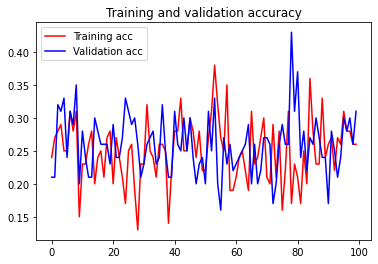

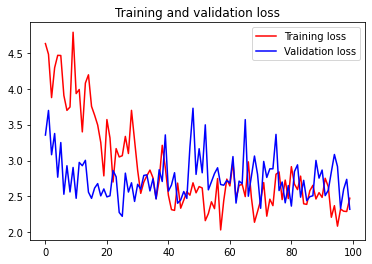

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'r', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'r', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## save model

In [17]:
os.makedirs("./content/drive/My Drive/Train", exist_ok=True)
model.save('./content/drive/My Drive/Train/Trainid10_Testid2_100.h5')

In [18]:
from google.colab import files

In [19]:
files.download("./content/drive/My Drive/Train/Trainid10_Testid2_100.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>